# Generative Adversional Network

In this jupyter notebook we will focus on $\textit{Generativ Adversional Networks}$ (GAN-s). The main focus for GAN is generating new data, f.e. photographs that look at least superficially authentic to human observers. GAN-s were introduced by Ian Goodfellow in 2014.
<br>


# Problem

In tradicional Neural Network we use it to perform a task of clasyfication, for a given set $D = \{(x_n, y_n)\}_{n=1}^N$ classify $\textit{y}$ for the new $\textbf{x}$. In GAN-s insted of classyfing we use our NN to create new data. To perform it we have to compose 2 neural netorks: 
1. Gnerator to create new data
2. Discriminator to say if our fake (generated) data is good enough




# Simple Example in Keras

In our simple example we will teach Generator how generate Gaussian Distribution plot. Mayby it is not the most interesting GANs application in the world, but it will give You a pretty good intuition about how GAN work.
<br><br>
Gaussian (also called Normal) distribution is a very common continuous probability distribution. Normal distributions are important in statistics and are often used in the natural and social sciences to represent real-valued random variables whose distributions are not known


$\mathcal{N}(\mu,\,\sigma^{2})\ = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{(x-\mu)^2}{2\sigma^{2}}}$
<br><br>
$\mu$ (mu) is the mean or expectation of the distribution 
<br>
$\sigma$ (sigma) is the standard deviation
<br>
$\sigma^2$ is the variance

# What we will do?

To train GAN we need both a real examples and examples generated by generator, as a real examples we will use Gaussians with randomy choosed $\mu$ and $\sigma$

In [14]:
import warnings
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm_notebook

In [15]:
mu = 0
variance = 1
sigma = np.sqrt(variance)

noise_size = 10

generated_samples_amount = 1000

batch_size = 50

learning_rate = 1e-2

x = np.linspace(-7, 7, generated_samples_amount)

## Gausian

$\mathcal{N}(\mu,\,\sigma^{2})\ = \frac{1}{{\sigma \sqrt {2\pi } }}e^{-\frac{(x-\mu)^2}{2\sigma^{2}}}$

In [16]:
def gaussian(x, mu, variance):
    """
    Args:
        x (np.linspace): the linspace on which the function will create distribution
        mu (float): mean value
        variance (float): variance value
    Returns:
        np.array: gausian distribution with provided parameters
    """
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(np.power(x-mu, 2.))/(2*variance))


## Example Gaussian Plot

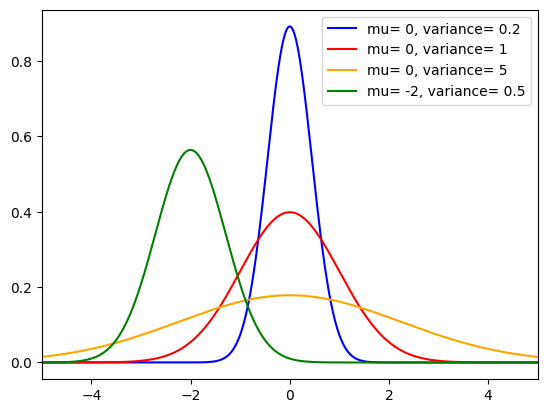

In [17]:
legend = "mu= {}, variance= {}"
plt.xlim([-5, 5])
plt.plot(x, gaussian(x, 0, .2), color= "blue", label = legend.format(0, .2))
plt.plot(x, gaussian(x, 0, 1), color= "red", label = legend.format(0, 1))
plt.plot(x, gaussian(x, 0, 5), color= "orange", label = legend.format(0, 5))
plt.plot(x, gaussian(x, -2, .5), color= "green", label = legend.format(-2, .5))
plt.legend()
plt.show()

# Data preparation


## Get random mean and sigma values

In [18]:
def get_new_mu_sigma():
    """
    Returns:
        float, float: new random values based on sigma and mu
    """
    new_mu = mu + np.random.randn()
    new_sigma = sigma + np.random.rand()

    return new_mu, new_sigma

## Generating randomized Gaussian Distribution

In [19]:
def get_gaussian_distribiution():
    """
    Returns:
        np.array: gaussian plotted on x linespace
    """
    new_mu, new_sigma = get_new_mu_sigma()
    
    return gaussian(x, new_mu, new_sigma)

## Add one layer of abstraction

To make this notebook easier to extend in future it is better to add one abstraction layer which will let us generate diffrent disctributions using GAN in future

In [20]:
def get_distribution(distribution_name):
    """
    Returns:
        distribution_name (str): name of wanted distribtion
    """
    distributions = {
        "gaussian": get_gaussian_distribiution,
    }

    try:
        distribution = distributions[distribution_name]()
    except KeyError:
        print("No such distribution, used default distribution: Gaussian")
        distribution = distributions["gaussian"]()

    return distribution


## Example

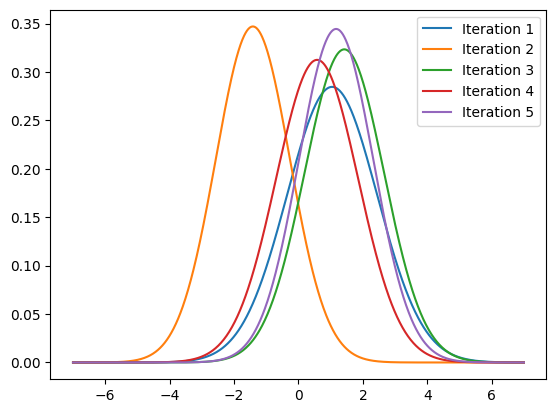

In [21]:
for i in range(5):
    plt.plot(x, get_distribution("gaussian"), label = "Iteration {}".format(i+1))

plt.legend()
plt.show()

## To make GAN training easier we will use Batches of real examples

In [22]:
def get_new_real_batch(distribution_name):
    """
    Returns:
        np.array: batch of gaussian_distributions plotted on x linespace
    """
    batches = np.array([get_distribution(distribution_name) for _ in range(batch_size)])
    return batches

## Example batch


In [23]:
batch = get_new_real_batch("gaussian")

print("Batch size: {}".format(batch_size))
print("Amount of samles generated by Generator {}".format(generated_samples_amount))

print("Batch shape: {}".format(batch.shape))    


Batch size: 50
Amount of samles generated by Generator 1000
Batch shape: (50, 1000)


## As an input for Generator Network we need some random values

In [24]:
def get_random_noise():
    """
    Returns:
        np.array: random noise, shape of generator input
    """
    random_noise = np.random.randn((noise_size)) / 10
    return random_noise

In [25]:
def get_new_random_noise_batch():
    """
    Reutrns:
        np.array: batch of random noises
    """
    batches = np.array([get_random_noise() for _ in range(batch_size)])
    return batches

# GAN Creation

One network generates candidates (generative) and the other evaluates them (discriminative). Generating Gaussian distribution is verry simple example so we can use verry simple Networks (both Genrator and Discriminator)


In [26]:
from keras import Sequential
from keras.layers import Dense, Input
from keras.optimizers import RMSprop
from keras.losses import mean_squared_error

## Generator

Generator will contain only one layer


In [27]:
def get_generator():
    """
    Returns:
        keras.engine.sequential.Sequential: compiled genrator model
    
    """
    model = Sequential()

    model.add(Dense(generated_samples_amount, input_shape=(noise_size,), activation="sigmoid"))

    model.compile(optimizer=RMSprop(lr=learning_rate), loss="binary_crossentropy")

    return model

## Discriminator

Discriminator will contain 2 layers


In [28]:
def get_discriminator():
    """
    Returns:
        keras.engine.sequential.Sequential: compiled discriminator model
    """
    model = Sequential()

    model.add(Dense(100, input_shape=(generated_samples_amount,), activation="sigmoid"))

    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=RMSprop(lr=learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

    return model


## GAN Creation
GAN composes discriminator and genrator but the discriminator weights ale not trainable. GAN model we will use to train Generator to generate distributions




In [29]:
def make_gan(generator, discriminator):
    """
    Args:
        discriminator (keras.engine.sequential.Sequential): compiled discriminator model
        generator (keras.engine.sequential.Sequential): compilted generator model
    Returns:
        keras.engine.sequential.Sequential : compiled GAN model, 
    """
    model = Sequential()

    discriminator.trainable = False

    model.add(generator)
    model.add(discriminator)

    model.compile(optimizer=RMSprop(lr=learning_rate), loss="binary_crossentropy", metrics=["accuracy"])

    return model


# Training

Training process contains 2 main actions:
    
    1. Train discriminator
    2. Train genrator
In trian generator we use GAN model (in which discriminator weighst are not trainable)  

In [30]:
def train(epochs):
    """
    Args:
        epochs (int): amount of training iterations
    Returns:
        keras.engine.sequential.Sequential, keras.engine.sequential.Sequential: trained generator and discriminator
    
    """
    generator = get_generator()

    discriminator = get_discriminator()

    gan = make_gan(generator, discriminator)

    for i in tqdm_notebook(range(epochs)):
        real_z = get_new_real_batch("gaussian")
        random_noise = get_new_random_noise_batch()
        false_z = generator.predict(random_noise)

        batch = np.concatenate((real_z, false_z))

        y = np.concatenate((np.ones(batch_size), np.zeros(batch_size)))

        # train discriminator
        accuracy = discriminator.train_on_batch(batch, y)

        # train generator
        gan.train_on_batch(random_noise, np.ones(batch_size))

    return generator, discriminator


# Testing 

After traing gereator we can see what shapes it generates, it should look like a gaussian curve.

  0%|          | 0/2000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


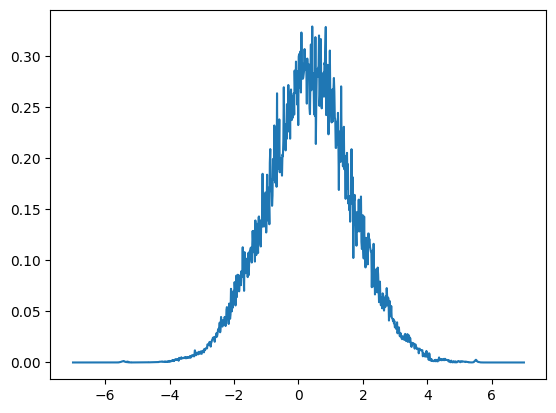

1/1 [==============================] - 0s 38ms/step


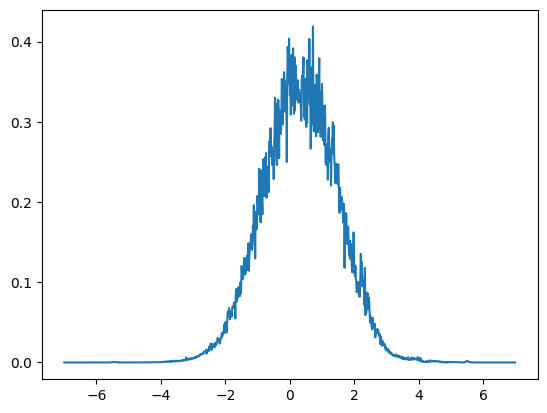

1/1 [==============================] - 0s 16ms/step


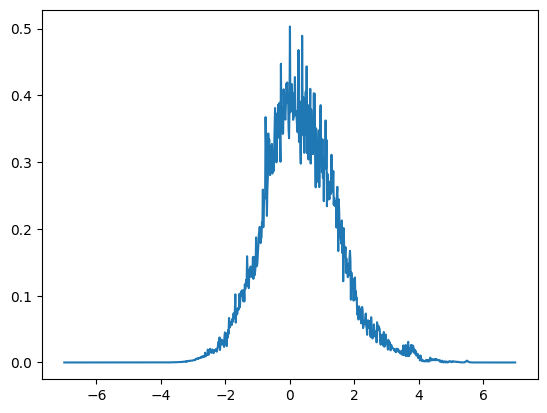

1/1 [==============================] - 0s 47ms/step


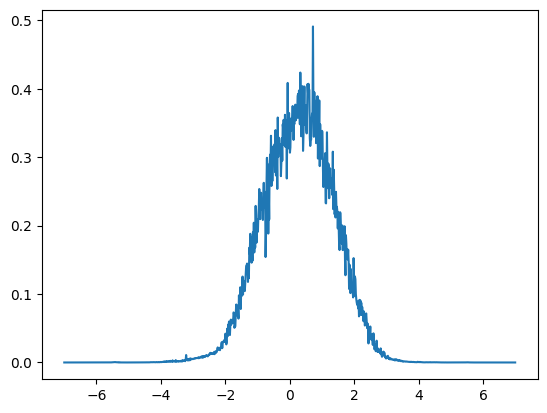

1/1 [==============================] - 0s 22ms/step


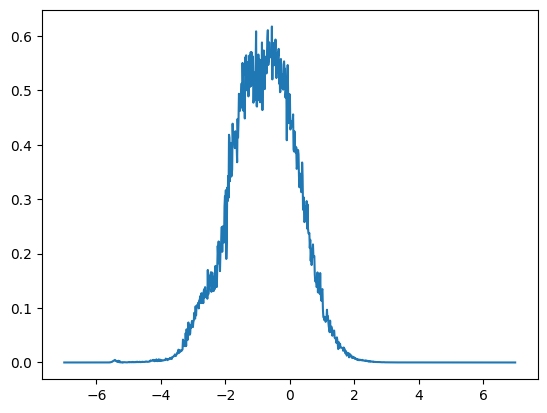

1/1 [==============================] - 0s 31ms/step


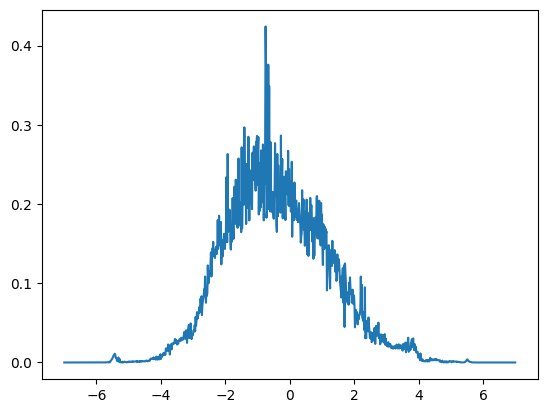

1/1 [==============================] - 0s 16ms/step


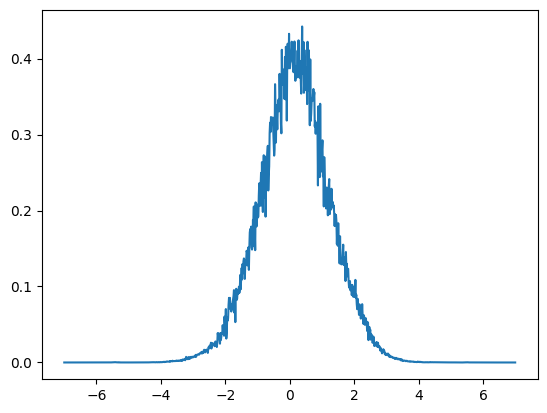

1/1 [==============================] - 0s 31ms/step


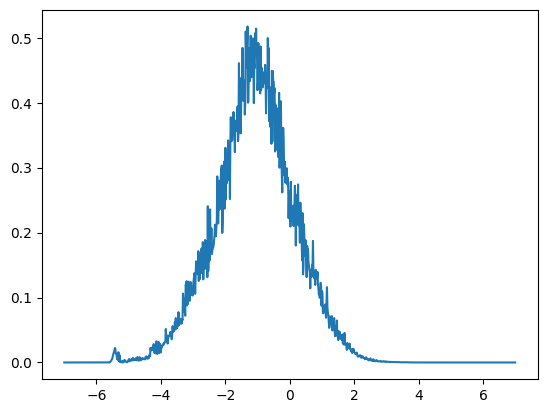

1/1 [==============================] - 0s 16ms/step


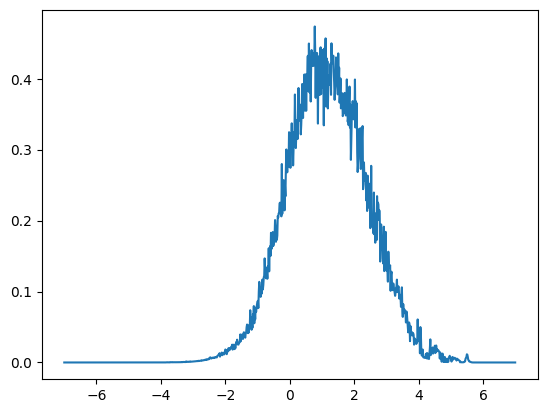

1/1 [==============================] - 0s 31ms/step


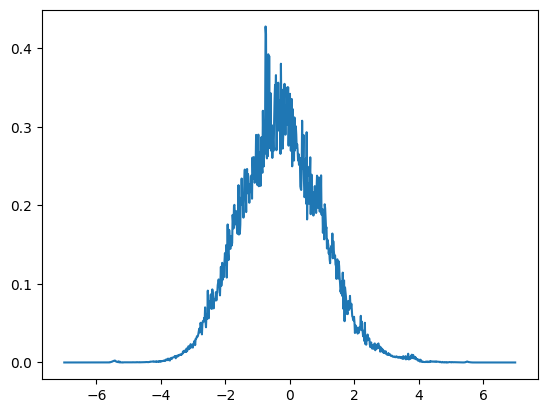

In [31]:
genrator, discriminator = train(epochs=2000)

for i in range(10):
    random_noise = np.random.randn((noise_size)) / 10
    random_noise = np.reshape(random_noise, (1, noise_size))

    distribution = genrator.predict(random_noise)
    
    distribution = np.reshape(distribution, (generated_samples_amount,))
    plt.plot(x, distribution)

    plt.show()


# Summary 

The generated graphs seem similar to real gaussian distributions. Of course it is not perfect but that mostly because of verry poor Networks used to this example. To perform better results we should use some more sofisticated networks (including CNNs or LSTMs). 
<br>


# Sources
https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/out.gif Face Gan example

https://cdn-images-1.medium.com/max/800/1*dWd0lVTbnu80UZM641gCbw.gif - Zebra GAN gif

https://github.com/david-gpu/srez super resulution GAN example

https://en.wikipedia.org/wiki/Normal_distribution Gaussian Plot example

https://medium.com/@devnag/generative-adversarial-networks-gans-in-50-lines-of-code-pytorch-e81b79659e3f- GAN "as dedective" photo

https://skymind.ai/wiki/generative-adversarial-network-gan- GAN architecture photo